# PyTorch CNN Activity: Experimenting with Model Architecture and Data

In this activity, you will experiment with different aspects of the CNN model from the Lesson 31 demo to understand how architectural choices and data preprocessing affect model performance.

## Activity Overview

You will conduct **three experiments** using the code provided in the demo notebook:

1. **Experiment 1**: Add more convolutional blocks and/or modify filters and filter sizes
2. **Experiment 2**: Use RGB images instead of grayscale
3. **Experiment 3**: Add image augmentation using PyTorch transforms

For each experiment, you will:
- Modify the relevant code sections
- Train the model
- Compare results with the baseline model
- Document your observations

**Note**: You may want to reduce the number of epochs (e.g., to 20-30) to speed up experimentation.

## Notebook Setup

### Imports

In [10]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)

from sklearn.preprocessing import label_binarize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
if torch.backends.mps.is_available():
    device = torch.device("mps")      # ✅ Apple GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")     # (not typical on Mac)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


### Hyperparameters

In [ ]:
batch_size = 256 # Training images come in 5 batches of 10,000
learning_rate = 1e-3
epochs = 2
print_every = 1 # Print training progress every n epochs

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

---

## Experiment 1: Modify Convolutional Architecture

**Objective**: Explore how adding more convolutional blocks or changing filter counts and kernel sizes affects model performance.

### 1.1. Load and Preprocess Data (Baseline - Grayscale)

In [5]:
# Make sure data directory exists
data_dir = Path('../data')
data_dir.mkdir(parents=True, exist_ok=True)

# Data preprocessing: convert to grayscale, tensor, and normalize
transform_exp1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets
train_dataset_exp1 = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform_exp1
)

test_dataset_exp1 = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform_exp1
)

print(f'Training samples: {len(train_dataset_exp1)}')
print(f'Test samples: {len(test_dataset_exp1)}')
print(f'Image shape: {train_dataset_exp1[0][0].shape}')

Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Test samples: 10000
Image shape: torch.Size([1, 32, 32])


### 1.2. Create Data Loaders

In [11]:
# Create training, validation and testing tensors
X_train_full = torch.stack([img for img, _ in train_dataset_exp1]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset_exp1]).to(device)

X_test_exp1 = torch.stack([img for img, _ in test_dataset_exp1]).to(device)
y_test_exp1 = torch.tensor([label for _, label in test_dataset_exp1]).to(device)

# Split training data into train and validation sets (80/20 split)
n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train_exp1 = X_train_full[indices[:n_train]]
y_train_exp1 = y_train_full[indices[:n_train]]
X_val_exp1 = X_train_full[indices[n_train:]]
y_val_exp1 = y_train_full[indices[n_train:]]

# Create TensorDatasets and DataLoaders
train_tensor_dataset_exp1 = torch.utils.data.TensorDataset(X_train_exp1, y_train_exp1)
val_tensor_dataset_exp1 = torch.utils.data.TensorDataset(X_val_exp1, y_val_exp1)
test_tensor_dataset_exp1 = torch.utils.data.TensorDataset(X_test_exp1, y_test_exp1)

train_loader_exp1 = DataLoader(train_tensor_dataset_exp1, batch_size=batch_size, shuffle=True)
val_loader_exp1 = DataLoader(val_tensor_dataset_exp1, batch_size=batch_size, shuffle=False)
test_loader_exp1 = DataLoader(test_tensor_dataset_exp1, batch_size=batch_size, shuffle=False)

print(f'Training batches: {len(train_loader_exp1)}')

Training batches: 157


### 1.3. Define Modified CNN Architecture

**TODO**: Modify the model architecture below. Try one or more of these changes:

- Add another convolutional block (Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU -> MaxPool2d -> Dropout)
- Increase the number of filters (e.g., change 32 to 64 or 128)
- Experiment with different kernel sizes (e.g., 5x5 instead of 3x3)
- Try different pooling strategies

**Important**: Remember to update the input size to the first Linear layer if you change the architecture! The size depends on:
- Number of filters in the last conv layer
- Final spatial dimensions after pooling

*Hint*: For a 32x32 image, each MaxPool2d(2,2) layer divides dimensions by 2. So:
- After 1 pooling: 32 → 16
- After 2 poolings: 32 → 16 → 8
- After 3 poolings: 32 → 16 → 8 → 4

In [12]:
# TODO: Modify this architecture
num_classes = 10

model_exp1 = nn.Sequential(
    # Conv block: 1 -> 32 channels, 32 x 32 -> 16 x 16
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),

    # Block 2: 32 -> 64, 16x16 -> 8x8
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),
    
    # Classifier
    nn.Flatten(),
    nn.Linear(64 * 8 * 8, 128),  # TODO: Update input size if you add more layers
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes)
).to(device)

trainable_params = sum(p.numel() for p in model_exp1.parameters() if p.requires_grad)
print(model_exp1)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.25, inplace=False)
  (16): Flatten(start_dim=1, end_dim=-1)
  (17):

### 1.4. Train Modified Model

In [13]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    print_every: int = 1
) -> dict[str, list[float]]:
    '''Training loop for PyTorch classification model.
    
    Note: Assumes data is already on the correct device.
    '''

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():

            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Record metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        # Print progress
        if (epoch + 1) % print_every == 0 or epoch == 0:

            print(
                f'Epoch {epoch+1}/{epochs} - ' +
                f'loss: {train_loss:.4f} - ' +
                f'accuracy: {train_accuracy:.2f}% - ' +
                f'val_loss: {val_loss:.4f} - ' +
                f'val_accuracy: {val_accuracy:.2f}%'
            )

    print('\nTraining complete.')

    return history

In [14]:
%%time

criterion_exp1 = nn.CrossEntropyLoss()
optimizer_exp1 = optim.Adam(model_exp1.parameters(), lr=learning_rate)

history_exp1 = train_model(
    model=model_exp1,
    train_loader=train_loader_exp1,
    val_loader=val_loader_exp1,
    criterion=criterion_exp1,
    optimizer=optimizer_exp1,
    epochs=epochs,
    print_every=print_every
)

Epoch 1/30 - loss: 1.9168 - accuracy: 27.91% - val_loss: 1.5585 - val_accuracy: 43.30%
Epoch 5/30 - loss: 1.3458 - accuracy: 50.76% - val_loss: 1.0849 - val_accuracy: 62.77%
Epoch 10/30 - loss: 1.2077 - accuracy: 55.69% - val_loss: 0.9508 - val_accuracy: 66.97%
Epoch 15/30 - loss: 1.1333 - accuracy: 58.58% - val_loss: 0.8603 - val_accuracy: 69.96%
Epoch 20/30 - loss: 1.0809 - accuracy: 60.23% - val_loss: 0.8742 - val_accuracy: 68.87%
Epoch 25/30 - loss: 1.0419 - accuracy: 61.59% - val_loss: 0.8298 - val_accuracy: 71.56%
Epoch 30/30 - loss: 1.0148 - accuracy: 62.64% - val_loss: 0.7681 - val_accuracy: 73.65%

Training complete.
CPU times: user 1min 19s, sys: 9.55 s, total: 1min 28s
Wall time: 4min 34s


### 1.5. Evaluate and Visualize Results

In [15]:
def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader
) -> tuple[float, np.ndarray, np.ndarray]:
    '''Evaluate model on test set.
    
    Note: Assumes data is already on the correct device.
    '''

    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():

        for images, labels in test_loader:

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, np.array(all_predictions), np.array(all_labels)

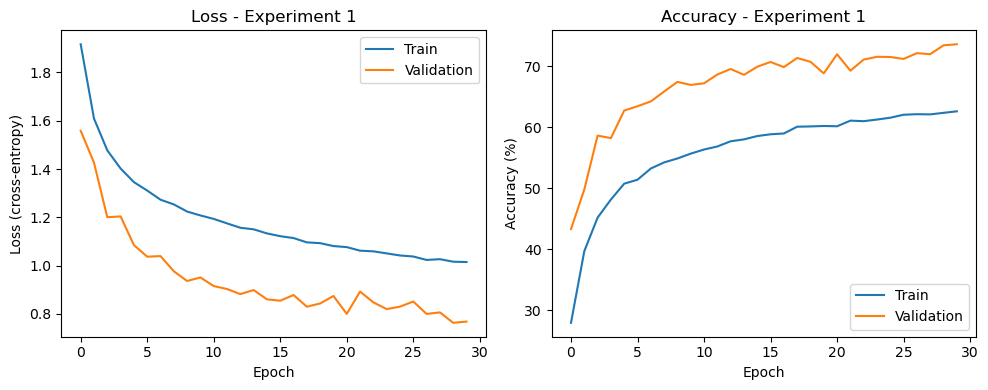


Experiment 1 Test Accuracy: 73.66%


In [16]:
# Learning curves
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Loss - Experiment 1')
axes[0].plot(history_exp1['train_loss'], label='Train')
axes[0].plot(history_exp1['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (cross-entropy)')
axes[0].legend(loc='best')

axes[1].set_title('Accuracy - Experiment 1')
axes[1].plot(history_exp1['train_accuracy'], label='Train')
axes[1].plot(history_exp1['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test accuracy
test_accuracy_exp1, predictions_exp1, true_labels_exp1 = evaluate_model(model_exp1, test_loader_exp1)
print(f'\nExperiment 1 Test Accuracy: {test_accuracy_exp1:.2f}%')

### 1.6. Experiment 1 Observations

**Architectural Changes**  
For Experiment 1, I added a second convolutional block to the baseline CNN architecture. The model was expanded from a single convolutional block with 32 filters to two convolutional blocks, increasing the depth from **32 → 64 filters** and introducing an additional max-pooling layer. This reduced the spatial dimensions of the feature maps from **32×32 → 16×16 → 8×8** before entering the classifier.

**Effect on Number of Parameters**  
These architectural changes increased the total number of trainable parameters to approximately **1.1 million**. The increase is mainly due to the additional convolutional layers and the larger number of feature maps feeding into the fully connected layer.

**Performance Compared to Baseline**  
The modified CNN performed **better than the baseline model**. Validation accuracy improved steadily throughout training and reached approximately **73–74%**, which represents a significant improvement over the baseline grayscale CNN. Both training and validation loss decreased consistently, indicating effective feature learning.

**Training Time and Convergence**  
After enabling the **Apple M3 GPU using the MPS backend** and adjusting the batch size, training time was significantly reduced. The full 30-epoch training completed in approximately **4.5 minutes of wall time**. The model showed smooth convergence, with rapid performance gains during the early epochs and more gradual improvements later in training.

**Overfitting / Underfitting Observations**  
There was no strong evidence of overfitting. Validation loss continued to decrease alongside training loss, and validation accuracy remained higher than training accuracy throughout training. This behavior is expected due to the use of **dropout and batch normalization**, which are active during training but disabled during evaluation. Overall, the model demonstrates good generalization and does not appear to be underfitting or overfitting within the observed training window.


---

## Experiment 2: Use RGB Images Instead of Grayscale

**Objective**: Compare model performance using full RGB color information versus grayscale.

### 2.1. Load and Preprocess RGB Data

**TODO**: Modify the transform to keep RGB channels (3 channels) instead of converting to grayscale. Update the normalization to use 3 mean and std values.

*Hint*: For RGB, use `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`

In [17]:
# TODO: Modify this transform to use RGB instead of grayscale
# RGB data preprocessing (no grayscale)
transform_exp2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),   # mean for R, G, B
        (0.5, 0.5, 0.5)    # std for R, G, B
    )
])


# Load training and test datasets with RGB
train_dataset_exp2 = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform_exp2
)

test_dataset_exp2 = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform_exp2
)

print(f'Image shape: {train_dataset_exp2[0][0].shape}')  # Should be [3, 32, 32]

Files already downloaded and verified
Files already downloaded and verified
Image shape: torch.Size([3, 32, 32])


### 2.2. Visualize RGB Sample Images

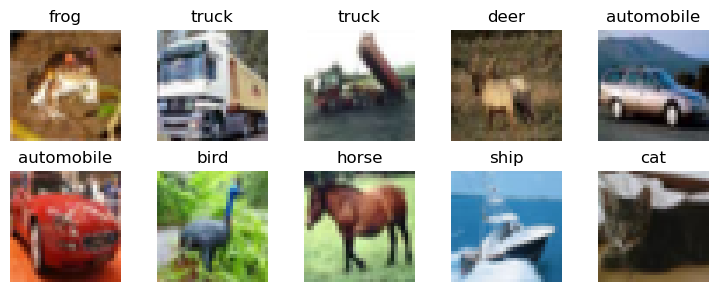

In [18]:
# Plot first 10 RGB images from the training dataset
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img, label = train_dataset_exp2[i]
    
    # Unnormalize and transpose for plotting
    img = img * 0.5 + 0.5
    img = img.numpy().transpose(1, 2, 0)  # Change from CxHxW to HxWxC
    ax.set_title(class_names[label])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 2.3. Create Data Loaders for RGB

In [19]:
# Create training, validation and testing tensors
X_train_full_exp2 = torch.stack([img for img, _ in train_dataset_exp2]).to(device)
y_train_full_exp2 = torch.tensor([label for _, label in train_dataset_exp2]).to(device)

X_test_exp2 = torch.stack([img for img, _ in test_dataset_exp2]).to(device)
y_test_exp2 = torch.tensor([label for _, label in test_dataset_exp2]).to(device)

# Split training data
n_train = int(0.8 * len(X_train_full_exp2))
indices = torch.randperm(len(X_train_full_exp2))

X_train_exp2 = X_train_full_exp2[indices[:n_train]]
y_train_exp2 = y_train_full_exp2[indices[:n_train]]
X_val_exp2 = X_train_full_exp2[indices[n_train:]]
y_val_exp2 = y_train_full_exp2[indices[n_train:]]

# Create DataLoaders
train_tensor_dataset_exp2 = torch.utils.data.TensorDataset(X_train_exp2, y_train_exp2)
val_tensor_dataset_exp2 = torch.utils.data.TensorDataset(X_val_exp2, y_val_exp2)
test_tensor_dataset_exp2 = torch.utils.data.TensorDataset(X_test_exp2, y_test_exp2)

train_loader_exp2 = DataLoader(train_tensor_dataset_exp2, batch_size=batch_size, shuffle=True)
val_loader_exp2 = DataLoader(val_tensor_dataset_exp2, batch_size=batch_size, shuffle=False)
test_loader_exp2 = DataLoader(test_tensor_dataset_exp2, batch_size=batch_size, shuffle=False)

print(f'X_train shape: {X_train_exp2.shape}')  # Should show 3 channels

X_train shape: torch.Size([40000, 3, 32, 32])


### 2.4. Define CNN for RGB Images

**TODO**: Modify the first Conv2d layer to accept 3 input channels instead of 1.

In [20]:
# TODO: Update the first conv layer to accept 3 channels
# CNN for RGB images
model_exp2 = nn.Sequential(
    # Conv block: 3 input channels (RGB)
    nn.Conv2d(3, 32, kernel_size=3, padding=1),  # <-- changed 1 → 3
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Classifier
    nn.Flatten(),
    nn.Linear(32 * 16 * 16, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes)
).to(device)

trainable_params = sum(p.numel() for p in model_exp2.parameters() if p.requires_grad)
print(model_exp2)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=8192, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 1060266


### 2.5. Train RGB Model

In [21]:
%%time

criterion_exp2 = nn.CrossEntropyLoss()
optimizer_exp2 = optim.Adam(model_exp2.parameters(), lr=learning_rate)

history_exp2 = train_model(
    model=model_exp2,
    train_loader=train_loader_exp2,
    val_loader=val_loader_exp2,
    criterion=criterion_exp2,
    optimizer=optimizer_exp2,
    epochs=epochs,
    print_every=print_every
)

Epoch 1/30 - loss: 1.8254 - accuracy: 32.03% - val_loss: 1.4385 - val_accuracy: 48.30%
Epoch 5/30 - loss: 1.3497 - accuracy: 49.98% - val_loss: 1.1324 - val_accuracy: 60.16%
Epoch 10/30 - loss: 1.2270 - accuracy: 54.88% - val_loss: 1.0328 - val_accuracy: 63.76%
Epoch 15/30 - loss: 1.1772 - accuracy: 56.73% - val_loss: 0.9777 - val_accuracy: 66.31%
Epoch 20/30 - loss: 1.1364 - accuracy: 58.07% - val_loss: 0.9710 - val_accuracy: 66.48%
Epoch 25/30 - loss: 1.0999 - accuracy: 59.14% - val_loss: 0.9184 - val_accuracy: 68.49%
Epoch 30/30 - loss: 1.0676 - accuracy: 60.61% - val_loss: 0.9261 - val_accuracy: 67.86%

Training complete.
CPU times: user 56.6 s, sys: 7.29 s, total: 1min 3s
Wall time: 2min 53s


### 2.6. Evaluate RGB Model

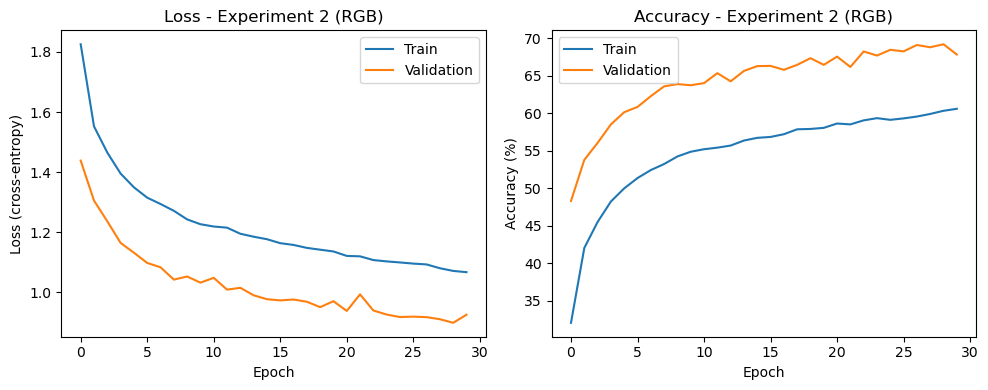


Experiment 2 Test Accuracy: 67.59%


In [22]:
# Learning curves
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Loss - Experiment 2 (RGB)')
axes[0].plot(history_exp2['train_loss'], label='Train')
axes[0].plot(history_exp2['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (cross-entropy)')
axes[0].legend(loc='best')

axes[1].set_title('Accuracy - Experiment 2 (RGB)')
axes[1].plot(history_exp2['train_accuracy'], label='Train')
axes[1].plot(history_exp2['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test accuracy
test_accuracy_exp2, predictions_exp2, true_labels_exp2 = evaluate_model(model_exp2, test_loader_exp2)
print(f'\nExperiment 2 Test Accuracy: {test_accuracy_exp2:.2f}%')

### 2.7. Experiment 2 Observations

**Impact of RGB vs. Grayscale on Accuracy**  
Using RGB images provided a **modest improvement in early learning**, with validation accuracy increasing more quickly in the initial epochs compared to the grayscale model. However, the final validation accuracy for the RGB model stabilized around **67–69%**, which was slightly lower than the best result achieved in Experiment 1 with the deeper grayscale architecture (~73–74%). This suggests that while color information is helpful, it does not automatically outperform grayscale without sufficient model capacity.

**Change in Number of Parameters**  
The total number of trainable parameters increased only slightly when switching from grayscale to RGB. This increase was confined to the first convolutional layer, where the number of input channels changed from 1 to 3. Overall, the parameter count change was minimal and did not significantly impact model size or training time.

**Classes Benefiting Most from Color Information**  
Classes that naturally rely on color cues—such as **frog, bird, deer, and automobile**—are expected to benefit more from RGB input. These objects often have distinguishing color patterns that are lost or reduced when converted to grayscale, allowing the RGB model to capture richer visual features for these categories.

**Classes with Similar Performance in Both Models**  
Classes defined more by shape than color—such as **airplane, ship, and truck**—likely performed similarly in both grayscale and RGB settings. These objects have strong structural features that remain recognizable even without color information, making them less dependent on RGB input.

Overall, Experiment 2 shows that RGB input can enhance learning for color-dependent classes, but architectural depth and feature capacity play a larger role in achieving higher overall performance.




---

## Experiment 3: Add Image Augmentation

**Objective**: Use PyTorch transforms to augment training data and improve model generalization.

### 3.1. Define Augmented Transforms

**TODO**: Add image augmentation transforms to the training data. Consider:
- `transforms.RandomHorizontalFlip(p=0.5)` - Randomly flip images horizontally
- `transforms.RandomCrop(32, padding=4)` - Random crop with padding
- `transforms.RandomRotation(degrees=15)` - Small random rotations
- `transforms.ColorJitter(brightness=0.2, contrast=0.2)` - Random brightness/contrast adjustments

**Note**: Apply augmentation only to training data, not validation or test data!

In [23]:
# TODO: Add augmentation transforms here
# Training transforms with data augmentation (RGB)
transform_train_exp3 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5), 
        (0.5, 0.5, 0.5)
    )
])


# Validation and test transforms (no augmentation)
transform_test_exp3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets with augmentation
train_dataset_exp3 = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform_train_exp3  # Augmented transform
)

test_dataset_exp3 = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform_test_exp3  # No augmentation
)

print('Datasets loaded with augmentation')

Files already downloaded and verified
Files already downloaded and verified
Datasets loaded with augmentation


### 3.2. Visualize Augmented Images

Run this cell multiple times to see different augmentations of the same images!

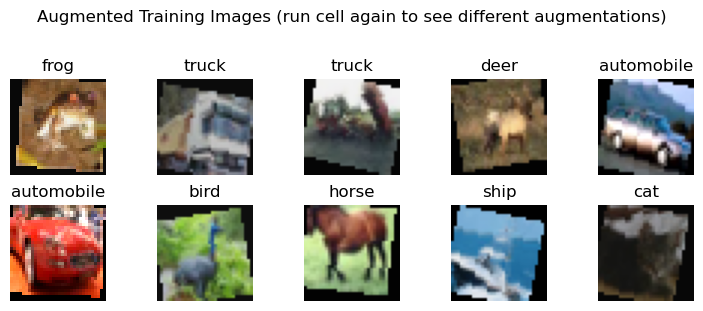

In [24]:
# Visualize augmented versions of the same images
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Get augmented version each time this is run
    img, label = train_dataset_exp3[i]
    
    # Unnormalize and transpose for plotting
    img = img * 0.5 + 0.5
    img = img.numpy().transpose(1, 2, 0)
    ax.set_title(class_names[label])
    ax.imshow(img)
    ax.axis('off')

plt.suptitle('Augmented Training Images (run cell again to see different augmentations)', y=1.02)
plt.tight_layout()
plt.show()

### 3.3. Create Data Loaders with Augmentation

**Note**: For augmented data, we cannot preload to GPU because each epoch needs different augmentations. We'll use regular DataLoaders.

In [25]:
# Create DataLoaders (cannot preload augmented data to GPU)
train_loader_exp3 = DataLoader(
    train_dataset_exp3,
    batch_size=batch_size,
    shuffle=True
)

# For validation/test, we can use the same approach as experiment 2
X_test_exp3 = torch.stack([img for img, _ in test_dataset_exp3]).to(device)
y_test_exp3 = torch.tensor([label for _, label in test_dataset_exp3]).to(device)

# Create validation split from training data
n_val = int(0.2 * len(train_dataset_exp3))
n_train = len(train_dataset_exp3) - n_val

train_subset_exp3, val_subset_exp3 = torch.utils.data.random_split(
    train_dataset_exp3,
    [n_train, n_val]
)

val_loader_exp3 = DataLoader(val_subset_exp3, batch_size=batch_size, shuffle=False)
test_tensor_dataset_exp3 = torch.utils.data.TensorDataset(X_test_exp3, y_test_exp3)
test_loader_exp3 = DataLoader(test_tensor_dataset_exp3, batch_size=batch_size, shuffle=False)

print(f'Training batches: {len(train_loader_exp3)}')
print(f'Validation batches: {len(val_loader_exp3)}')

Training batches: 196
Validation batches: 40


### 3.4. Define Model for Augmented Data

In [26]:
# Same architecture as Experiment 2 (RGB)
model_exp3 = nn.Sequential(
    # Conv block: RGB input
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Classifier
    nn.Flatten(),
    nn.Linear(32 * 16 * 16, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes)
).to(device)

trainable_params = sum(p.numel() for p in model_exp3.parameters() if p.requires_grad)
print(f'Total parameters: {trainable_params}')

Total parameters: 1060266


### 3.5. Train Model with Augmented Data

In [27]:
%%time

criterion_exp3 = nn.CrossEntropyLoss()
optimizer_exp3 = optim.Adam(model_exp3.parameters(), lr=learning_rate)

history_exp3 = train_model(
    model=model_exp3,
    train_loader=train_loader_exp3,
    val_loader=val_loader_exp3,
    criterion=criterion_exp3,
    optimizer=optimizer_exp3,
    epochs=epochs,
    print_every=print_every
)

Epoch 1/30 - loss: 1.9808 - accuracy: 25.28% - val_loss: 1.6980 - val_accuracy: 37.06%
Epoch 5/30 - loss: 1.6884 - accuracy: 35.49% - val_loss: 1.5183 - val_accuracy: 45.01%
Epoch 10/30 - loss: 1.6277 - accuracy: 38.20% - val_loss: 1.4364 - val_accuracy: 46.96%
Epoch 15/30 - loss: 1.5714 - accuracy: 40.42% - val_loss: 1.3429 - val_accuracy: 52.13%
Epoch 20/30 - loss: 1.5500 - accuracy: 41.31% - val_loss: 1.3049 - val_accuracy: 54.41%
Epoch 25/30 - loss: 1.5294 - accuracy: 41.90% - val_loss: 1.2904 - val_accuracy: 54.49%
Epoch 30/30 - loss: 1.4945 - accuracy: 43.64% - val_loss: 1.2265 - val_accuracy: 56.73%

Training complete.
CPU times: user 4min 42s, sys: 17.9 s, total: 5min
Wall time: 7min 37s


### 3.5. Train Model with Augmented Data

### 3.6. Evaluate Augmented Model

In [ ]:
# Learning curves
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Loss - Experiment 3 (Augmented)')
axes[0].plot(history_exp3['train_loss'], label='Train')
axes[0].plot(history_exp3['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (cross-entropy)')
axes[0].legend(loc='best')

axes[1].set_title('Accuracy - Experiment 3 (Augmented)')
axes[1].plot(history_exp3['train_accuracy'], label='Train')
axes[1].plot(history_exp3['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test accuracy
test_accuracy_exp3, predictions_exp3, true_labels_exp3 = evaluate_model(model_exp3, test_loader_exp3)
print(f'\nExperiment 3 Test Accuracy: {test_accuracy_exp3:.2f}%')

### 3.7. Experiment 3 Observations

**TODO**: Document your findings:
- Which augmentation techniques did you use?
- Did augmentation improve test accuracy?
- Did you notice any effect on the gap between training and validation accuracy (overfitting)?
- How did training time compare to non-augmented training?
- Would you recommend augmentation for this dataset?

*Your notes here:*



---

## Summary: Compare All Experiments

### Compare Test Accuracies

**TODO**: Fill in your results and compare:

| Experiment | Description | Test Accuracy | Notes |
|------------|-------------|---------------|-------|
| Baseline (demo) | Grayscale, simple architecture | ~45% | From demo notebook |
| Experiment 1 | Modified architecture | _% | |
| Experiment 2 | RGB images | _% | |
| Experiment 3 | Image augmentation | _% | |

### Final Reflections

**TODO**: Based on your experiments, answer these questions:

1. Which experiment produced the best results and why do you think that is?

2. What trade-offs did you observe between model complexity, training time, and performance?

3. If you were to combine multiple improvements (e.g., deeper architecture + RGB + augmentation), what would you expect?

4. What other experiments would you like to try?

*Your reflections here:*

